In [46]:
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from deap import base, creator, tools, algorithms

In [47]:
# Entrada -> Universo de Discurso e Variaveis linguísticas
temp = ctrl.Antecedent(np.arange(0, 101, 0.5), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 0.5), 'humidity')
# Consequente
velocity = ctrl.Consequent(np.arange(0, 100, 0.5), 'velocity', defuzzify_method='mom')

c:\Users\João Marcos\OneDrive\Área de Trabalho\Prog\Git\Fuzzy-Project\.venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


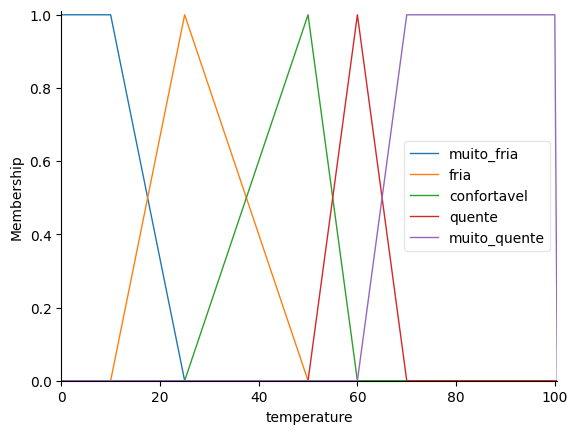

In [48]:
#Pertinencia da Temperatura
temp['muito_fria'] = fuzz.trapmf(temp.universe, [-1, 0, 10, 25])
temp['fria'] = fuzz.trimf(temp.universe, [10, 25, 50])
temp['confortavel'] = fuzz.trimf(temp.universe, [25, 50, 60])
temp['quente'] = fuzz.trimf(temp.universe, [50, 60, 70])
temp['muito_quente'] = fuzz.trapmf(temp.universe, [60, 70, 100, 100])
temp.view()

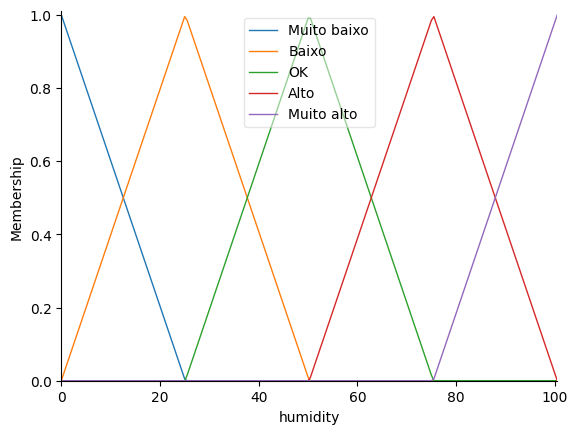

In [49]:
#Pertinencia da Humidade
humidity.automf(5, names=['Muito baixo','Baixo','OK','Alto','Muito alto'])
humidity.view()

In [50]:
velocity['baixa'] = fuzz.trimf(velocity.universe, [0, 0, 50])
velocity['média'] = fuzz.trimf(velocity.universe, [0, 50, 100])
velocity['alta'] = fuzz.trimf(velocity.universe, [50, 100, 100])

In [51]:
regra1 = ctrl.Rule(temp['muito_fria'] & humidity['Baixo'], velocity['alta'])
regra2 = ctrl.Rule(temp['fria'] & humidity['Baixo'], velocity['média'])
regra3 = ctrl.Rule(temp['confortavel'] & humidity['OK'], velocity['média'])
regra4 = ctrl.Rule(temp['quente'] & humidity['Alto'], velocity['baixa'])
regra5 = ctrl.Rule(temp['muito_quente'] & humidity['Alto'], velocity['baixa'])

In [52]:
sistema_controle = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5])
controle = ctrl.ControlSystemSimulation(sistema_controle)

controle.input['temperature'] = 75
controle.input['humidity'] = 70

In [53]:
# Realizando a inferência
controle.compute()

# Obtendo a saída
print("Velocidade da Ventoinha:", controle.output['velocity'])

Velocidade da Ventoinha: 5.486805104910231


In [54]:
# GErando dados para teste
temps = np.linspace(0, 100, 25)
hums = np.linspace(0, 100, 25)

data = []
for T in temps:
    for H in hums:
        vel_real = 0.6*T + 0.4*H
        data.append([T, H, vel_real])

df = pd.DataFrame(data, columns=["temp", "hum", "vel"])
df

,temp,hum,vel
0,0.0,0.000000,0.000000
1,0.0,4.166667,1.666667
2,0.0,8.333333,3.333333
3,0.0,12.500000,5.000000
4,0.0,16.666667,6.666667
...,...,...,...
620,100.0,83.333333,93.333333
621,100.0,87.500000,95.000000
622,100.0,91.666667,96.666667
623,100.0,95.833333,98.333333


## Iniciando Algoritmo Genético

### Inicializando o modelo

In [55]:
# Limpa creators anteriores se existirem
if hasattr(creator, "FitnessMin"):
    del creator.FitnessMin
if hasattr(creator, "Individual"):
    del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_float", lambda: random.uniform(10, 90))  # Evita extremos
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 15)  # 5+5+5 parâmetros
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Função para controle do sistema

In [56]:
def repair_params(params_group):
    """
    Repara um grupo de 5 parâmetros garantindo:
    - Valores entre 0 e 100
    - Ordenação crescente
    - Separação mínima de 5 unidades
    """
    # Limita e ordena
    params_group = sorted([max(0, min(100, p)) for p in params_group])
    
    # Distribui uniformemente se estiverem muito próximos
    if params_group[4] - params_group[0] < 20:  # Muito comprimidos
        start = params_group[0]
        params_group = [start + i*5 for i in range(5)]
        if params_group[4] > 100:
            params_group = [20 + i*20 for i in range(5)]  # Fallback: distribuição uniforme
    else:
        # Ajusta separação mínima
        for i in range(4):
            if params_group[i+1] - params_group[i] < 5:
                params_group[i+1] = params_group[i] + 5
        
        # Se ultrapassou 100, redistribui
        if params_group[4] > 100:
            # Comprime proporcionalmente
            old_range = params_group[4] - params_group[0]
            scale = 100 / (params_group[4] + 5)
            params_group = [p * scale for p in params_group]
    
    return [max(0, min(100, p)) for p in params_group]


In [57]:
def build_fuzzy_system(params):
    """
    Constrói sistema fuzzy com os parâmetros fornecidos
    params: lista de 15 valores (5 temp + 5 hum + 5 vel)
    """
    # Separa e repara os parâmetros
    temp_params = repair_params(params[0:5])
    hum_params = repair_params(params[5:10])
    vel_params = repair_params(params[10:15])
    
    t1, t2, t3, t4, t5 = temp_params
    h1, h2, h3, h4, h5 = hum_params
    v1, v2, v3, v4, v5 = vel_params

    # Definição das variáveis fuzzy
    temp = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')
    hum = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')
    velocity = ctrl.Consequent(np.arange(0, 101, 1), 'velocity')

    # Funções de pertinência - Temperatura (PARAMETRIZADAS)
    temp['muito_fria'] = fuzz.trapmf(temp.universe, [0, 0, t1, t2])
    temp['fria'] = fuzz.trimf(temp.universe, [t1, t2, t3])
    temp['confort'] = fuzz.trimf(temp.universe, [t2, t3, t4])
    temp['quente'] = fuzz.trimf(temp.universe, [t3, t4, t5])
    temp['muito_quente'] = fuzz.trapmf(temp.universe, [t4, t5, 100, 100])

    # Funções de pertinência - Umidade (PARAMETRIZADAS)
    hum['muito_baixo'] = fuzz.trapmf(hum.universe, [0, 0, h1, h2])
    hum['baixo'] = fuzz.trimf(hum.universe, [h1, h2, h3])
    hum['medio'] = fuzz.trimf(hum.universe, [h2, h3, h4])
    hum['alto'] = fuzz.trimf(hum.universe, [h3, h4, h5])
    hum['muito_alto'] = fuzz.trapmf(hum.universe, [h4, h5, 100, 100])

    # Funções de pertinência - Velocidade (PARAMETRIZADAS)
    velocity['muito_baixa'] = fuzz.trapmf(velocity.universe, [0, 0, v1, v2])
    velocity['baixa'] = fuzz.trimf(velocity.universe, [v1, v2, v3])
    velocity['media'] = fuzz.trimf(velocity.universe, [v2, v3, v4])
    velocity['alta'] = fuzz.trimf(velocity.universe, [v3, v4, v5])
    velocity['muito_alta'] = fuzz.trapmf(velocity.universe, [v4, v5, 100, 100])

    # Regras fuzzy - CONJUNTO COMPLETO
    rules = []
    
    # Temperatura muito fria
    rules.append(ctrl.Rule(temp['muito_fria'] & hum['muito_baixo'], velocity['alta']))
    rules.append(ctrl.Rule(temp['muito_fria'] & hum['baixo'], velocity['alta']))
    rules.append(ctrl.Rule(temp['muito_fria'] & hum['medio'], velocity['media']))
    rules.append(ctrl.Rule(temp['muito_fria'] & hum['alto'], velocity['media']))
    rules.append(ctrl.Rule(temp['muito_fria'] & hum['muito_alto'], velocity['baixa']))
    
    # Temperatura fria
    rules.append(ctrl.Rule(temp['fria'] & hum['muito_baixo'], velocity['alta']))
    rules.append(ctrl.Rule(temp['fria'] & hum['baixo'], velocity['media']))
    rules.append(ctrl.Rule(temp['fria'] & hum['medio'], velocity['media']))
    rules.append(ctrl.Rule(temp['fria'] & hum['alto'], velocity['baixa']))
    rules.append(ctrl.Rule(temp['fria'] & hum['muito_alto'], velocity['baixa']))
    
    # Temperatura confortável
    rules.append(ctrl.Rule(temp['confort'] & hum['muito_baixo'], velocity['alta']))
    rules.append(ctrl.Rule(temp['confort'] & hum['baixo'], velocity['media']))
    rules.append(ctrl.Rule(temp['confort'] & hum['medio'], velocity['media']))
    rules.append(ctrl.Rule(temp['confort'] & hum['alto'], velocity['media']))
    rules.append(ctrl.Rule(temp['confort'] & hum['muito_alto'], velocity['baixa']))
    
    # Temperatura quente
    rules.append(ctrl.Rule(temp['quente'] & hum['muito_baixo'], velocity['media']))
    rules.append(ctrl.Rule(temp['quente'] & hum['baixo'], velocity['media']))
    rules.append(ctrl.Rule(temp['quente'] & hum['medio'], velocity['baixa']))
    rules.append(ctrl.Rule(temp['quente'] & hum['alto'], velocity['baixa']))
    rules.append(ctrl.Rule(temp['quente'] & hum['muito_alto'], velocity['muito_baixa']))
    
    # Temperatura muito quente
    rules.append(ctrl.Rule(temp['muito_quente'] & hum['muito_baixo'], velocity['baixa']))
    rules.append(ctrl.Rule(temp['muito_quente'] & hum['baixo'], velocity['baixa']))
    rules.append(ctrl.Rule(temp['muito_quente'] & hum['medio'], velocity['muito_baixa']))
    rules.append(ctrl.Rule(temp['muito_quente'] & hum['alto'], velocity['muito_baixa']))
    rules.append(ctrl.Rule(temp['muito_quente'] & hum['muito_alto'], velocity['muito_baixa']))

    # Criação do sistema
    sistema = ctrl.ControlSystem(rules)
    return ctrl.ControlSystemSimulation(sistema)

### Função de Fitness

In [58]:
def evaluate(individual):
    """
    Avalia um indivíduo calculando o erro médio quadrático
    entre a predição do sistema fuzzy e os valores reais
    """
    try:
        sistema = build_fuzzy_system(individual)
        erros = []

        # Amostra aleatória para avaliação
        amostra = df.sample(min(50, len(df)), random_state=42)

        for _, row in amostra.iterrows():
            try:
                sistema.input['temperature'] = float(row.temp)
                sistema.input['humidity'] = float(row.hum)
                sistema.compute()
                
                # Extrai a velocidade predita
                vel_pred = sistema.output['velocity']
                erro = (vel_pred - row.vel)**2
                erros.append(erro)
                    
            except Exception as e:
                # Se falhar em um caso, penaliza mas não tanto
                erros.append(1000)
        
        if len(erros) == 0:
            return (1e9,)
        
        # Retorna MSE médio
        return (np.mean(erros),)
        
    except Exception as e:
        print(f"Erro na avaliação: {e}")
        return (1e9,)


In [59]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Mais exploração
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.4)  # Mutação maior
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
print("Iniciando Algoritmo Genético...")
print("="*60)

POPULATION_SIZE = 40 
NUM_GENERATIONS = 30
CROSSOVER_PROB = 0.7
MUTATION_PROB = 0.3

pop = toolbox.population(n=POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
stats.register("max", np.max)

hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop, 
    toolbox, 
    cxpb=CROSSOVER_PROB, 
    mutpb=MUTATION_PROB, 
    ngen=NUM_GENERATIONS, 
    stats=stats,
    halloffame=hof,
    verbose=True
)

# ==================== RESULTADOS ====================
print("\n" + "="*60)
print("RESULTADOS FINAIS")
print("="*60)

best = hof[0]
best_temp = sorted(best[0:5])
best_hum = sorted(best[5:10])
best_vel = sorted(best[10:15])

print(f"\nMelhores parâmetros encontrados:")
print(f"\n  TEMPERATURA:")
print(f"    t1 = {best_temp[0]:.2f}")
print(f"    t2 = {best_temp[1]:.2f}")
print(f"    t3 = {best_temp[2]:.2f}")
print(f"    t4 = {best_temp[3]:.2f}")
print(f"    t5 = {best_temp[4]:.2f}")
print(f"\n  UMIDADE:")
print(f"    h1 = {best_hum[0]:.2f}")
print(f"    h2 = {best_hum[1]:.2f}")
print(f"    h3 = {best_hum[2]:.2f}")
print(f"    h4 = {best_hum[3]:.2f}")
print(f"    h5 = {best_hum[4]:.2f}")
print(f"\n  VELOCIDADE:")
print(f"    v1 = {best_vel[0]:.2f}")
print(f"    v2 = {best_vel[1]:.2f}")
print(f"    v3 = {best_vel[2]:.2f}")
print(f"    v4 = {best_vel[3]:.2f}")
print(f"    v5 = {best_vel[4]:.2f}")
print(f"\nErro médio quadrático (MSE): {best.fitness.values[0]:.4f}")
print(f"Raiz do erro quadrático (RMSE): {np.sqrt(best.fitness.values[0]):.4f}")


Iniciando Algoritmo Genético...
gen	nevals	min    	avg    	max    
0  	40    	1142.13	1571.66	1990.55
1  	32    	998.52 	1470.87	2057.71
2  	33    	949.575	1307.37	1854.08
3  	31    	949.575	1233.54	1514.57
4  	31    	879.19 	1139.21	1390.65
5  	31    	879.19 	1098.01	1469.91
6  	33    	845.279	1036.58	1240.39
7  	33    	846.042	1013.54	1343.25
8  	29    	846.042	944.883	1169.86
9  	33    	850.958	924.125	1096.44
10 	35    	832.982	887.611	1010.89
11 	32    	832.982	885.022	1149.25
12 	28    	825.274	866.514	1116.6 
13 	36    	821.065	869.219	1029.37
14 	34    	821.065	865.349	950.346
15 	28    	781.987	851.937	993.134
16 	38    	824.619	846.779	910.702
17 	31    	800.18 	850.846	1055.06
18 	33    	800.18 	846.124	976.612
19 	31    	790.792	854.277	1024.54
20 	34    	787.562	852.919	1040.55
21 	31    	787.562	840.219	931.937
22 	36    	785.591	840.203	924.6  
23 	29    	777.023	827.136	983.562
24 	32    	777.023	811.061	950.991
